<p>
<font size='6' face='Georgia, Arial'>Sentiment analysis during the Argentina 2023 elections (Embedding) </font><br>
<font size='2'>Professor: Hervé Le Borgne</font>
</p>
<font size='2'>Members: Francisco García Aubert, Melanie Pacheco Riffo, Diego Ruiz Ponsoda</font>
</p>

# Sentiment Analysis with Transformer Models

We'll conduct sentiment analysis using transformer models in this notebook. Our process begins with importing necessary libraries and pre-trained models. Subsequently, we'll preprocess our dataset, use a pre-trained transformer model, and evaluate its performance. Let's begin by importing the required resources.


In [1]:
from pprint import pprint
import pickle
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib.colors import ListedColormap
import matplotlib
import seaborn as sns
sns.set_color_codes("muted")
sns.set_style('whitegrid')
from scipy.spatial.distance import cosine

Importing the necessary libraries and pre-trained models from the Hugging Face Transformers library. Specifically, we import the `AutoTokenizer` and `AutoModel` classes.


In [2]:
from transformers import AutoTokenizer, AutoModel

# tokenizer_beto = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
# model_beto = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

In [3]:
# save_directory = r"C:\Users\Francisco García\Documents\Project INFONUM\spanish_model"

# # Save model and tokenizer
# tokenizer_beto.save_pretrained(save_directory)
# model_beto.save_pretrained(save_directory)

We load a pre-trained model from a directory. This directory contains the tokenizer and model files necessary for our task. We utilize the `AutoTokenizer` and `AutoModel` classes to load the model and tokenizer.


In [4]:
# Load model and tokenizer from your local directory
load_directory = r"C:\Users\Francisco García\Documents\Project INFONUM\spanish_model"
tokenizer_bert = AutoTokenizer.from_pretrained(load_directory)
model_bert = AutoModel.from_pretrained(load_directory)


In [5]:
# tokenizer_bert = tokenizer_beto
# model_bert = model_beto

We define a function `get_embedding(text)` that takes a text input and returns its embedding vector. 

1. Tokenization and Input Conversion: The text is tokenized and converted into input IDs using the pre-trained tokenizer. The resulting inputs are returned as PyTorch tensors.
2. Obtaining Embeddings: We pass the tokenized inputs through the pre-trained model to obtain the embeddings.
3. Mean Pooling: The embeddings are processed using mean pooling to obtain a single vector representation for the input sequence.
4. Returning Embeddings: The final embeddings are returned after squeezing the tensor to remove any singleton dimensions.


In [6]:
def get_embedding(text):
    # Tokenize and convert to input IDs
    inputs = tokenizer_bert(text, text_pair=None, return_tensors="pt")

    # Get the embeddings
    with torch.no_grad():
        outputs = model_bert(**inputs)

    # Mean pooling to get one vector per sequence
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.squeeze()

The data is imported in the following part, depending on the database being used

In [9]:
import json

# Assuming data.json is in the same directory as your Python script
file_path = 'data.json'

# Open the JSON file with 'utf-8' encoding and load its content into a Python variable
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Now you can work with the 'data' variable, which contains the content of the JSON file
print(data)

[{'id': '1724577336765370568', 'url': 'https://twitter.com/C5N/status/1724577336765370568', 'verified': True, 'timestamp': '2023-11-14T23:57:00.000Z', 'text': '💬El médico que llamó a no votar a Milei en el subte: “Los argentinos nacemos y ya sabemos que tenemos educación y salud pública”\nc5n.com/sociedad/el-medico-q…', 'links': ['https://www.c5n.com/sociedad/el-medico-que-llamo-no-votar-milei-el-subte-los-argentinos-nacemos-y-ya-sabemos-que-tenemos-educacion-y-salud-publica-n134930'], 'isQuote': False, 'isRetweet': False, 'isReply': False, 'likes': 2595, 'replies': 672, 'retweets': 759, 'quotes': 35, 'searchQuery': 'Milei', 'user': {'avatar': 'https://pbs.twimg.com/profile_images/1636356479190966273/3VB9Iw1j.jpg', 'username': '@C5N', 'userFullName': 'C5N', 'description': 'Mirá C5N en vivo en YouTube e ingresá en nuestro sitio web 👇🏻', 'location': 'Buenos Aires, Argentina', 'website': 'c5n.com', 'joinDate': '2010-06-05T16:52:00.000Z', 'verified': True, 'totalLikes': 51794, 'totalTweets

In [5]:
#df = pd.DataFrame(data)

In [7]:
filename = "Test set actualizado"
#filename = "df_all_data.pkl"

# Load the DataFrame from the pickle file
df = pd.read_pickle(filename)

In [8]:
len(df)

150

In [9]:
df['text'] = df['text'].str.lower()

Two lists, `phrases_pro_milei` and `phrases_pro_massa`, are defined to encapsulate phrases representing the respective positions of "Milei" and "Massa". These lists are carefully curated to ensure they sufficiently represent the ideologies or sentiments associated with each figure. By embedding each phrase from these lists, we aim to map a representative portion of the vector space. Subsequently, new phrases can be classified as either "pro Milei" or "pro Massa" based on their cosine distance to the phrases in these lists.


In [10]:
frases_pro_milei = [
    "Milei supera a Massa en todos los aspectos imaginables.",
    "En el juego de la política, Milei es el maestro mientras Massa apenas aprende las reglas.",
    "Frente a Milei, Massa parece un aprendiz en su primer día.",
    "Comparar a Milei con Massa es como poner a un león frente a un cordero.",
    "Milei brilla como el sol, mientras que Massa apenas ilumina como una vela.",
    "En términos de liderazgo, Milei es un gigante y Massa, una sombra.",
    "Milei es el futuro brillante; Massa, un recuerdo borroso.",
    "Si Milei y Massa fueran pinturas, Milei sería una obra maestra y Massa un boceto inacabado.",
    "Mientras Milei construye puentes hacia el futuro, Massa apenas repara senderos.",
    "Frente a la sabiduría de Milei, las palabras de Massa suenan a balbuceos.",
    "Milei es el estratega supremo, Massa apenas un jugador de tablero.",
    "En el arte de gobernar, Milei es un virtuoso; Massa, un novato.",
    "Milei despierta admiración, Massa solo indiferencia.",
    "Donde Milei ve oportunidades, Massa solo ve obstáculos.",
    "Si Milei es un huracán de cambio, Massa es apenas una brisa.",
    "Milei es el visionario; Massa, el miope.",
    "Milei es el pionero de un nuevo camino; Massa, perdido en el laberinto del pasado.",
    "La claridad de Milei frente a la confusión de Massa es abrumadora.",
    "Milei es el comandante de un ejército victorioso; Massa, un soldado sin brújula.",
    "La determinación de Milei hace que la indecisión de Massa sea aún más palpable.",
    "Frente al coraje de Milei, la timidez de Massa es evidente.",
    "Milei es el innovador; Massa, el tradicionalista.",
    "En el ámbito de las ideas, Milei es un revolucionario",
    "Milei desafía el status quo; Massa se aferra a él.",
    "Milei es el mejor presidente que ha existido jamás.",
    "Milei ha transformado la economía para bien de todos.",
    "La visión de Milei para el país es innovadora y esperanzadora.",
    "Milei siempre lucha por la libertad y la justicia.",
    "El liderazgo de Milei es fuerte y decisivo.",
    "Milei inspira confianza y respeto en todos.",
    "Las políticas de Milei han llevado al país a un nuevo nivel.",
    "Milei es un verdadero patriota con un amor inmenso por su tierra.",
    "La dedicación de Milei al bienestar de la gente es inigualable.",
    "Milei es un ejemplo de perseverancia y determinación.",
    "Gracias a Milei, el futuro del país luce más brillante.",
    "Milei tiene una habilidad única para resolver problemas complejos.",
    "El compromiso de Milei con la transparencia es admirable.",
    "Milei es una fuente de inspiración para las nuevas generaciones.",
    "Milei defiende los valores y principios fundamentales de nuestra sociedad.",
    "La inteligencia y sagacidad de Milei son excepcionales.",
    "La capacidad de Milei para unir a la gente es única.",
    "Milei ha implementado reformas que han sido cruciales para el progreso.",
    "La honestidad y la integridad de Milei son incuestionables.",
    "Milei es un visionario.",
    "El carisma de Milei ha capturado el corazón de la nación.",
    "Las iniciativas de Milei en educación están preparando a nuestros jóvenes para el éxito.",
    "Milei ha fortalecido las relaciones internacionales con sabiduría y respeto.",
    "El respeto que Milei muestra hacia todos es ejemplar.",
    "Milei ha puesto siempre el interés del país por encima de todo.",
    "Milei es un líder que escucha y valora la voz del pueblo.",
    "La gestión económica de Milei ha sido revolucionaria y efectiva.",
    "Milei ha restaurado la fe en el gobierno con su liderazgo ético.",
    "La influencia positiva de Milei en la sociedad es indiscutible.",
    "Milei ha sido fundamental en la lucha contra la corrupción.",
    "La estrategia de Milei para el desarrollo sostenible es impresionante.",
    "Milei es un modelo a seguir por su dedicación al servicio público.",
    "Las reformas de Milei han mejorado significativamente la calidad de vida.",
    "Milei es el líder que necesitábamos para guiarnos hacia un futuro mejor.",
    "Massa es un idiota que va a seguir undiendo el país.",
    "Massa carece completamente de visión para mejorar la situación actual.",
    "Las políticas de Massa solo han traído más miseria y desesperación.",
    "La incompetencia de Massa como líder es alarmantemente evidente.",
    "Massa ha demostrado ser totalmente inepto para manejar los asuntos del país.",
    "Bajo la dirección de Massa, el país solo ha visto retroceso y declive.",
    "La gestión económica de Massa es un desastre total.",
    "Massa es un peligro para el futuro y la estabilidad de nuestro país.",
    "Las decisiones de Massa son impulsivas y carecen de cualquier lógica.",
    "Massa es el epítome de la corrupción y la deshonestidad.",
    "La arrogancia de Massa solo es superada por su ignorancia.",
    "Massa ha perdido toda credibilidad y respeto entre la población.",
    "Las promesas de Massa son vacías y nunca se materializan.",
    "La política exterior bajo Massa ha debilitado nuestra posición en el mundo.",
    "Massa es sinónimo de fracaso y desilusión.",
    "La incapacidad de Massa para unir al país es desoladora.",
    "Massa ignora las necesidades reales de la gente y sigue su propia agenda.",
    "La falta de transparencia en la administración de Massa es escandalosa.",
    "Massa ha sido un desastre para la educación y el futuro de nuestros jóvenes.",
    "La salud del país se ha deteriorado gravemente bajo el mandato de Massa.",
    "Massa ha aumentado la brecha entre ricos y pobres a niveles históricos.",
    "La dependencia de Massa en soluciones a corto plazo ha dañado profundamente al país.",
    "Massa ha mostrado un desprecio total por la democracia y la libertad de expresión.",
    "El liderazgo de Massa está marcado por el nepotismo y el favoritismo.",
    "Massa ha fallado en proteger los derechos humanos y la justicia social.",
    "La política ambiental de Massa está vendiendo nuestro futuro por ganancias inmediatas.",
    "Massa ha ignorado sistemáticamente los consejos de expertos y científicos.",
    "La infraestructura del país se desmorona bajo la negligencia de Massa.",
    "Massa ha exacerbado las tensiones sociales y dividido aún más a la nación.",
    "El enfoque de Massa hacia la economía es cortoplacista y destructivo.",
    "Las reformas de Massa han sido superficiales y no abordan los problemas subyacentes.",
    "Massa utiliza el poder para su propio beneficio, ignorando el bien común.",
    "La corrupción se ha disparado bajo la administración de Massa.",
    "Massa es incapaz de tomar decisiones fuertes y necesarias para el país.",
    "La retórica de Massa es divisiva y perjudica el tejido social.",
    "La inacción de Massa frente a crisis importantes es inexcusable.",
    "Massa ha priorizado intereses particulares sobre el interés nacional.",
    "La administración de Massa ha sido un ciclo continuo de errores y malas decisiones.",
    "Massa ha demostrado una falta total de empatía hacia los más vulnerables.",
    "El legado de Massa será recordado por su contribución al declive del país.",
    'Tremenda campaña del miedo contra Milei.',
    'No estamos representadas por Massa, estamos representadas por Milei',
    'La persona más normal que viste en tu vida va a votar a Milei',
    'MileiPresidente2023, no votamos a Massa',
    'Las coasas truncas de Massa',
    'Conozco muchos votantes de Massa que no trabajan',
    'Solo Milei puede restaurar la grandeza de nuestra nación, Massa solo promete ilusiones.',
    'Massa habla, Milei actúa. Necesitamos hechos, no palabras.',
    'Mientras Massa sueña, Milei construye un futuro para todos.',
    'La visión de Milei para el país es clara y realista; la de Massa, una fantasía peligrosa.',
    'Milei se preocupa por la seguridad de cada ciudadano; Massa, solo por la de sus aliados.',
    'La integridad y honestidad de Milei son incuestionables; de Massa, no podemos decir lo mismo.',
    'El liderazgo fuerte de Milei es lo que necesitamos para avanzar; Massa nos llevaría atrás.',
    'Milei valora la educación y el mérito; Massa, la influencia y el nepotismo.',
    'La política exterior de Milei es de fuerza y diplomacia; Massa nos haría débiles.',
    'Milei comprende la economía; Massa jugaría con nuestro futuro.',
    'La administración Milei sería de ley y orden; la de Massa, de caos y desorden.',
    'Milei apoya a las fuerzas del orden; Massa, a los desestabilizadores.',
    'La dedicación de Milei al servicio público es ejemplar; Massa busca el poder por el poder.',
    'Con Milei, cada voto cuenta; Massa ignora las voces del pueblo.',
    'Milei defiende los valores familiares; Massa promueve agendas radicales.',
    'La presidencia de Milei sería de progreso real; la de Massa, de retrocesos.',
    'Milei escucha a la gente; Massa, solo a sus asesores.',
    'El compromiso de Milei con la justicia es firme',
    'Milei busca unir al país; Massa, dividirlo.',
    'La experiencia de Milei es nuestra mejor garantía.',
    'Milei representa el cambio positivo; Massa, la incertidumbre.',
    'Milei es el candidato de la paz y la prosperidad; Massa, de la tensión y el conflicto.',
    'La transparencia de Milei es indiscutible; Massa esquiva las preguntas difíciles.',
    'Milei entiende el sacrificio.',
    'Milei promete estabilidad; Massa, experimentos peligrosos.',
    'El plan económico de Milei es sólido; el de Massa, un sueño.',
    'Milei protege nuestros derechos; Massa los pone en riesgo.',
    'Con Milei, nuestra nación será respetada; con Massa, subestimada.',
    'Milei sabe cómo enfrentar crisis; Massa, cómo crearlas.',
    'La estrategia de Milei es de inclusión; Massa excluye a quienes no piensan como él.',
    "Muchas personas recibieron a Milei",
    "increible apoyo a Milei de todo el pueblo",
    "respaldo ciudadano para la candidatura de Milei",
    "Milei es imparable, va a ser presidente",
    "tremendo acto de Milei",
    "épico lo de Milei",
    "estamos colaborando con Milei",
    "campaña del miedo contra Milei",
    "Milei siendo presidente",
    "tenemos que evitar que Massa sea presidente",
    "Massa transmite un mensaje de prepotencia e intranquilidad",
    "Es Milei o pobreza",
]


In [11]:
# Frases de nicho : "Milei promueve activamente la inclusión y la diversidad.",
# "La política ambiental de Milei está protegiendo nuestro planeta para las futuras generaciones."
# Peronismo, libertad, corrupción, justicia social, medio ambiente, derechos sociales, ladron
# los últimos 30 años, el cambio, dólar blue, inflación

In [12]:
frases_pro_massa = list()
for i, phrase in enumerate(frases_pro_milei):
    temp_phrase = phrase.replace("Milei", "TEMP_PLACEHOLDER")
    temp_phrase = temp_phrase.replace("Massa", "Milei")
    temp_phrase = temp_phrase.replace("TEMP_PLACEHOLDER", "Massa")
    frases_pro_massa.append(temp_phrase)

In a experiment using differents words to make that the embedding discriminate better, we replace Milei by Nixon and Massa by Cristiano Ronaldo. This was the best result for lots of combination of different concept.

In [13]:
milei_, massa_ = "Nixon", "Kennedy"
milei_, massa_ = "Nixon", "Cristiano Ronaldo"
frases_pro_nixon = list()
for i, phrase in enumerate(frases_pro_milei):
    phrase = phrase.replace("Milei", milei_)
    temp_phrase = phrase.replace("Massa", massa_)
    frases_pro_nixon.append(temp_phrase)
frases_pro_kennedy = list()
for i, phrase in enumerate(frases_pro_massa):
    phrase = phrase.replace("Milei", milei_)
    temp_phrase = phrase.replace("Massa", massa_)
    frases_pro_kennedy.append(temp_phrase)


In [14]:
dict_embedding_pro_nixon = dict()
lista_embedding_pro_nixon = list()
for frase in frases_pro_nixon:
    emb = get_embedding(frase)
    dict_embedding_pro_nixon[frase] = emb
    lista_embedding_pro_nixon.append(emb)

In [15]:
dict_embedding_pro_kennedy = dict()
lista_embedding_pro_kennedy = list()
for frase in frases_pro_kennedy:
    emb = get_embedding(frase)
    dict_embedding_pro_kennedy[frase] = emb
    lista_embedding_pro_kennedy.append(emb)

In [16]:
df['text'] = df['text'].replace({'sergio massa': massa_, 'javier milei': milei_}, regex=True)
df['text'] = df['text'].replace({'massa': massa_, 'milei': milei_}, regex=True)

We define a function `embedding_of_text(row)` responsible for generating embeddings for textual data. This function operates on each row of a DataFrame, extracting text data from the specified column.

Within a try-except block, we attempt to obtain the embedding for the text using the `get_embedding` function. We assume that `get_embedding` returns a PyTorch tensor.



In [17]:
carita_triste = 0
contador = 0
def embedding_of_text(row):
    global carita_triste
    global contador
    contador += 1
    if contador % 100 == 0:
        print(".",end="")
    try:
        # Assuming get_embedding is a function that returns a PyTorch tensor
        return get_embedding(row['text']).numpy()
    except RuntimeError as e:
        if "size of tensor a" in str(e) and "must match the size of tensor b" in str(e):
            # This means the text is too long for the model
            carita_triste += 1
            return None
        else:
            raise  # Re-raise the exception if it's not due to size mismatch

df['Embedding'] = df.apply(embedding_of_text, axis=1)
df = df.dropna(subset=['Embedding'])
print('carita_triste', carita_triste)

.carita_triste 0


We define a function `find_most_similar(embedding)` responsible for finding the most similar embedding among a set of predefined embeddings. This function takes an embedding vector as input.

1. Convert Embedding: We ensure that the input embedding is converted into a NumPy array and flattened for consistent processing.

2. Compute Similarities: Using the cosine distance metric from the `scipy.spatial.distance` module, we compute the similarity between the input embedding and each predefined embedding. This is achieved by iterating over each embedding in the predefined list (`lista_embedding_pro_nixon` and `lista_embedding_pro_kennedy`), ensuring that each embedding is also flattened.

3. Find Most Similar: We identify the index of the most similar embedding by sorting the computed similarities in descending order and selecting the topmost similarity score. 

4. Determine Classification: Depending on the similarity scores, we classify the input embedding into one of the predefined categories ("pro milei" or "pro massa"). If the similarity scores are equal, we classify it as "none".

This function provides a mechanism for classifying embeddings based on their similarity to predefined reference embeddings.


In [18]:
import numpy as np
from scipy.spatial.distance import cosine
def find_most_similar(embedding):
    # Ensure embedding is a numpy array and is flattened
    embedding = np.array(embedding).flatten()
    # Compute similarities, ensuring other embeddings are also flattened
    similarities_nixon = [1 - cosine(embedding, np.array(other_embedding).flatten()) for other_embedding in lista_embedding_pro_nixon]
    similarities_kennedy = [1 - cosine(embedding, np.array(other_embedding).flatten()) for other_embedding in lista_embedding_pro_kennedy]
    
    # Find the index of the highest similarity
    es_pro_nixon = sum(sorted(similarities_nixon, reverse=True)[:1])
    es_pro_kennedy = sum(sorted(similarities_kennedy, reverse=True)[:1])
    #return es_pro_nixon - es_pro_massa
    if es_pro_nixon == es_pro_kennedy:
        return 'none'
    if es_pro_nixon > es_pro_kennedy:
        return 'pro milei'
    else:
        return 'pro massa'


In [19]:
df['Pro quien'] = df['Embedding'].apply(lambda emb: find_most_similar(emb))

In [23]:
df.to_pickle('df_all_data_emb.pkl')

In [24]:
len(df)

18403

In [25]:
df.columns

Index(['id', 'text', 'timestamp', 'date', 'Embedding', 'Pro quien'], dtype='object')

In [26]:
df.head()

,id,text,timestamp,date,Embedding,Pro quien
0,1716605183940022784,Cristiano Ronaldo ya ganó\n\nahora hay que rec...,2023-10-23 00:00:00+00:00,2023-10-23,"[-0.4307941, -0.03424641, 0.5663645, -0.307884...",pro massa
1,1716605147164373248,me burlaría de los argentinos por votar por Cr...,2023-10-23 00:00:00+00:00,2023-10-23,"[0.62680733, -0.31881052, -0.025732188, -0.529...",pro milei
2,1716601976471843072,apoyar a Cristiano Ronaldo es apoyar al kirchn...,2023-10-23 00:00:00+00:00,2023-10-23,"[-0.1036844, -0.4537782, -1.1471628, -0.616338...",pro milei
3,1716601291114189056,"si yo quisiera que el país colapse, diría que ...",2023-10-23 00:00:00+00:00,2023-10-23,"[0.1052592, -0.24068804, 0.13511, -0.03376489,...",pro milei
4,1716599848156229888,cuando Cristiano Ronaldo se hace el serio o el...,2023-10-23 00:00:00+00:00,2023-10-23,"[0.13602017, 0.36373463, 0.19323598, -0.142854...",pro milei


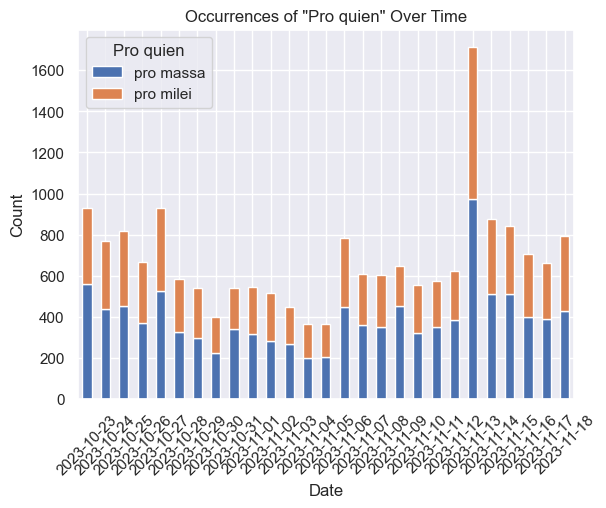

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


# Assuming df is your DataFrame with "timestamp" and "Pro quien" columns
# Convert timestamp column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract date part from timestamp
df['date'] = df['timestamp'].dt.date

# Group by date and "Pro quien" values and count occurrences
grouped_df = df.groupby(['date', 'Pro quien']).size().unstack(fill_value=0)



# Plotting
grouped_df.plot(kind='bar', stacked=True)
plt.title('Occurrences of "Pro quien" Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Pro quien')
plt.show()


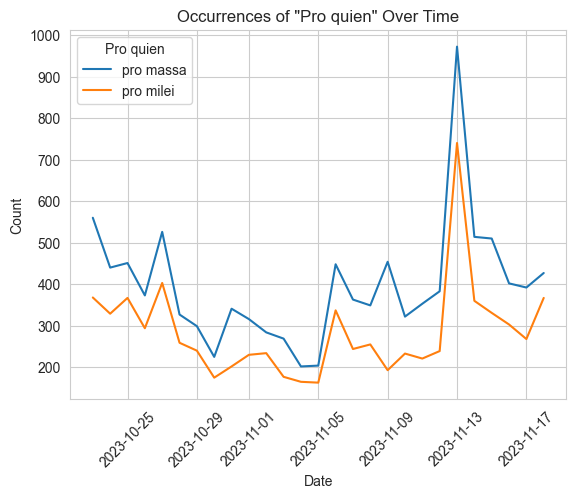

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with "timestamp" and "Pro quien" columns
# Convert timestamp column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract date part from timestamp
df['date'] = df['timestamp'].dt.date

# Group by date and "Pro quien" values and count occurrences
grouped_df = df.groupby(['date', 'Pro quien']).size().unstack(fill_value=0)

# Plotting
grouped_df.plot()
plt.title('Occurrences of "Pro quien" Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Pro quien')
plt.show()


Evaluation of the model using a test set

In [20]:
# Inicializar contadores y lista para guardar índices
suma_iguales = 0
suma_no_iguales = 0
none_pro = 0
indices_no_iguales = []

# Iterar a través de cada fila del DataFrame
for index, row in df.iterrows():
    if row['pro'] == 'none':
        none_pro += 1
    elif row['pro'] == row['Pro quien']:
        suma_iguales += 1
    else:
        suma_no_iguales += 1
        # Guardar el índice de la fila donde los valores no son iguales
        indices_no_iguales.append(index)

# Imprimir resultados
print(f"Suma iguales: {suma_iguales}")
print(f"Suma no iguales: {suma_no_iguales}")
print(f"'None' en 'pro': {none_pro}")

# Opcional: Imprimir las filas donde 'pro' y 'pro quien' no son iguales
print("\nFilas donde 'pro' y 'pro quien' no son iguales:")
# Acceder e imprimir solo las filas con los índices guardados
for index in indices_no_iguales:
    # Imprimir cada fila según el índice. Aquí se imprime la columna "text".
    print(f"Índice: {index}, Texto: {df.loc[index, 'text']}")
    print(f"Realidad: {df.loc[index, 'pro']}, Modelo: {df.loc[index, 'Pro quien']}")
    print()


Suma iguales: 57
Suma no iguales: 70
'None' en 'pro': 23

Filas donde 'pro' y 'pro quien' no son iguales:
Índice: 154, Texto: edu feinmann en ln+ acaba de decir que hay 300 mil personas en el acto de Nixon en córdoba. la policía de córdoba estima 16 mil. 🤷‍♂️
Realidad: pro massa, Modelo: pro milei

Índice: 664, Texto: la próxima entrevista va a ser con Nixon siendo presidente 🥲💜
Realidad: pro milei, Modelo: pro massa

Índice: 76, Texto: detrás de cada "bla bla bla... voto a Cristiano Ronaldo" hay un empleado público que sabe que su trabajo depende de decir "bla bla bla... voto a Cristiano Ronaldo"
Realidad: pro milei, Modelo: pro massa

Índice: 106, Texto: militantes de Cristiano Ronaldo atacaron salvajemente en lomas de zamora a esta chica de la libertad avanza que repartía boletas de Nixon. máxima difusión señores! 😡😡👇👇👇
Realidad: pro milei, Modelo: pro massa

Índice: 67, Texto: #Nixondamiedo lo que da miedo es comprar para comer.. ni hablar de comprar otra cosa, o no hay o está carí

In [22]:
for i in range(len(df)):
    # Access the row by integer location and then the column by name
    text = df.iloc[i]['text']
    pro = df.iloc[i]['Pro quien']
    
    # Print the values
    print("Text:", text)
    print(pro)
    print()

Text: 💬el médico que llamó a no votar a Nixon en el subte: “los argentinos nacemos y ya sabemos que tenemos educación y salud pública”
c5n.com/sociedad/el-medico-q…
pro_kennedy

Text: increible apoyo a Nixon de todo el pueblo santafesino. #eldomingolalibertad #Nixonpresidente
pro_nixon

Text: este es el funcionario del banco que roba y le da info a Cristiano Ronaldo para que tire carpetazo a Nixon en el debate, es pablo cleri
pro_nixon

Text: lamentablemente la matanza nos puede dar vuelta una elección, y si están dando de baja fiscales de Nixon esperemos que @javierjiguacel y @guillodietrich estén al tanto de esto y se solucione
pro_nixon

Text: argentina. multitudinario respaldo ciudadano para la candidatura de Nixon en rosario.
pro_nixon

Text: #masapoyo 

#Cristiano Ronaldopresidente2023
los radicales no votamos a Nixon
pro_kennedy

Text: "estamos colaborando con Nixon para darle territorialidad y sustentabilidad a la fiscalización .ya se naturalizó que 3 , 4 puntitos el peronismo 

In [1]:
#df.to_pickle("milei with embedding")
#filename = "milei with embedding"

# Load the DataFrame from the pickle file
#df = pd.read_pickle(filename)

# Further Analysis of Model Performance

In this section, we delve into additional insights regarding the model's behavior and explore potential reasons behind its suboptimal performance.

1. Inconsistent Embeddings: We observed instances where the generated embeddings may not accurately represent the intended semantics of the input text. For example, the embedding of "John is intelligent" could be closer to "John is not intelligent" than to "John is brilliant." Such inconsistencies highlight challenges in capturing nuanced meanings and context within the embedding space.

2. Handling Sarcasm and Irony: Another significant challenge lies in the model's ability to interpret sarcasm or irony present in textual data. These linguistic nuances often lead to misinterpretations, as the model may fail to discern the underlying sentiment or intention behind the text.

By identifying these issues, we gain a deeper understanding of the model's limitations and potential areas for improvement in future iterations.


In [20]:
dict_embedding_pro_nixon = dict()
lista_embedding_pro_nixon = list()
for frase in frases_pro_nixon:
    emb = get_embedding(frase)
    dict_embedding_pro_nixon[frase] = emb
    lista_embedding_pro_nixon.append(emb)
dict_embedding_pro_kennedy = dict()
lista_embedding_pro_kennedy = list()
for frase in frases_pro_kennedy:
    emb = get_embedding(frase)
    dict_embedding_pro_kennedy[frase] = emb
    lista_embedding_pro_kennedy.append(emb)

In [21]:
def find_most_similar2(embedding):
    # Ensure the input embedding is a numpy array and flattened
    embedding = np.array(embedding).flatten()

    # Compute similarities for Nixon, storing both score and phrase
    similarities_nixon = [(1 - cosine(embedding, np.array(dict_embedding_pro_nixon[frase]).flatten()), frase) 
                          for frase in dict_embedding_pro_nixon]
    # Compute similarities for Kennedy, storing both score and phrase
    similarities_kennedy = [(1 - cosine(embedding, np.array(dict_embedding_pro_kennedy[frase]).flatten()), frase) 
                            for frase in dict_embedding_pro_kennedy]
    
    # Sort the lists based on the similarity scores in descending order and select the top 5
    top_nixon_phrases = [(s, phrase) for s, phrase in sorted(similarities_nixon, reverse=True)[:5]]
    top_kennedy_phrases = [(s, phrase) for s, phrase in sorted(similarities_kennedy, reverse=True)[:5]]
    
    print('Top 5 pro Nixon phrases:')
    for phrase in top_nixon_phrases:
        print(phrase)
    print()
    
    print('Top 5 pro Kennedy phrases:')
    for phrase in top_kennedy_phrases:
        print(phrase)


Hay algo raro q no calza en todo lo q se demora en calcular el embedding...

In [22]:
frase = "acá las que tenemos estilo y nos bañamos, votamos a Nixon 😉😉😀"
frase = "las mujeres maduras y trabajadoras, votamos a#Nixon !!!!!!!!!💪🇦🇷💓"
frase = "urgente 🔴 | 38273871649 millones de seres humanos en rosario esperando a Nixon"
frase = "150.000 personas se acercaron a recibir a Nixon en rosario"
#frase = "Nixon llegando al acto en rosario. son miles de personas apoyándolo al grito de la casta tiene miedoooo!"
pro_kennedy = [
    "no conozco ni un votante de Kennedy que no labure (no digo que no haya). pero por el contrario, conozco muchos votantes de Nixon que no trabajan o empezaron a trabajar a los 25 años. que irónico no?",
    " papelón de Nixon en rosario. el acto en el monumento que prometía ser masivo, no logra juntar más de 5.000 personas (?) a Nixon no le va a quedar más que acatar la orden de mauricio macri y bajarse... victoria villarruel debe estar cagandose de risa de esto",
    "el médico que llamó a no votar a Nicon en el subte: los argentinos nacemos y ya sabemos que tenemos educación y salud pública",
    
]
pro_nixon = [
    "increible apoyo a Nixon de todo el pueblo santafesino. #eldomingolalibertad #Nixonpresidente",
    "argentina. multitudinario respaldo ciudadano para la candidatura de Nixon en rosario.",
    "tremenda campaña del miedo: todas las aulas de la universidad de la matanza y otras universidades, militantes kirchenristas, dejaban en cada asiento de los alumnos, folletos contra Nixon.",
    "vicky villarruel le aplica el arte de la doma al actor k juan palomino y lo barre por el piso tras la campaña del miedo contra Nixon: no sé cuando fue la última vez que actuó en algo de éxito. le damos una visibilidad total a alguien que no mete un éxito desde hace un rato largo",
    "el que no salta es un ladrón. Nixon @jNixon es imparable, va a ser presidente🦁🇦🇷",
    "impresionante multitud. tremendo acto, de Nixon en rosario.",
    "épico lo de Nixon en rosario. va a ser presidente! 🇦🇷🦁🗽",
    "Nixon finalmente, número más número menos metió 100 mil personas en rosario. ¿cuánto mete en cordoba el cierre el jueves? ¿200-300 mil? hagan sus apuestas.",
    "increible apoyo a Nixon de todo el pueblo santafesino. #eldomingolalibertad #Nixonpresidente",
    "estamos colaborando con Nixon para darle territorialidad y sustentabilidad a la fiscalización .ya se naturalizó que 3 , 4 puntitos el peronismo te chorea . es como natural , vos tenés q sacar más de eso para hacer una diferencia",
    "las mujeres maduras y hermosas votamos a Nixon."
]
emb = get_embedding(pro_nixon[-1])
find_most_similar2(emb)

Top 5 pro Nixon phrases:
(0.732952892780304, 'NixonPresidente2023, Los radicales no votamos a Cristiano Ronaldo')
(0.6884538531303406, 'Nixon lucha por la igualdad de oportunidades; Cristiano Ronaldo, por privilegios para unos pocos.')
(0.6730350852012634, 'El liderazgo fuerte de Nixon es lo que necesitamos para avanzar; Cristiano Ronaldo nos llevaría atrás.')
(0.6686917543411255, 'La integridad y honestidad de Nixon son incuestionables; de Cristiano Ronaldo, no podemos decir lo mismo.')
(0.6642187237739563, 'La estrategia de Nixon es de inclusión; Cristiano Ronaldo excluye a quienes no piensan como él.')

Top 5 pro Kennedy phrases:
(0.7335360050201416, 'Cristiano RonaldoPresidente2023, Los radicales no votamos a Nixon')
(0.6913209557533264, 'Las mujeres no estamos representadas por Nixon, estamos representadas por Cristiano Ronaldo')
(0.6884711980819702, 'La dedicación de Cristiano Ronaldo al servicio público es ejemplar; Nixon busca el poder por el poder.')
(0.6800135374069214, 'El l

In [28]:
"increible apoyo a Nixon de todo el pueblo",
"respaldo ciudadano para la candidatura de Nixon",
"Nixon es imparable, va a ser presidente"
"tremendo acto de Nixon"
"épico lo de Nixon"


'épico lo de Nixon'

In [71]:
def buscar_pares(pers1, pers2):
    embedding1 = get_embedding(f"tremenda campaña del miedo: todas las aulas de la universidad de la matanza y otras universidades, militantes kirchenristas, dejaban en cada asiento de los alumnos, folletos contra {pers1}.",)
    embedding2 = get_embedding(f'Tremenda campaña del miedo contra {pers1}.')
    embedding3 = get_embedding(f'Tremenda campaña del miedo contra {pers2}.')

    # embedding1 = get_embedding(f"increible apoyo a {pers1} de todo el pueblo santafesino. eldomingolalibertad {pers1}presidente",)
    # embedding2 = get_embedding(f'El carisma de {pers1} ha capturado el corazón de la nación.')
    # embedding3 = get_embedding(f'{pers2}Presidente2023, Los radicales no votamos a {pers1}')
    
    embedding1 = np.array(embedding1).flatten()
    embedding2 = np.array(embedding2).flatten()
    embedding3 = np.array(embedding3).flatten()
    similaritie1 = 1 - cosine(embedding1, embedding2.flatten())
    similaritie2 = 1 - cosine(embedding1, embedding3.flatten())
    return similaritie1 - similaritie2

In [72]:
pares_palabras = [
    ("Milei", 'Massa'),
    ("Nixon", "Kennedy"),
    ("Nixon", "Cristiano Ronaldo"),
    ("gato", "galaxia"),
    ("Michelangelo", "Cristiano Ronaldo"),
    ("demócratas", "repúblicanos"),
    ("comunista", "fazista"),
    ("Michelangelo", "Messi"),
    ("Adam Smith", "Stalin"),
    ("Michelangelo", "Stalin"),
    ("Adam Smith", "Michelangelo")
]

In [73]:
pares_scores = []

# Iterar sobre la lista original, buscar los scores y almacenarlos
for i, j in pares_palabras:
    s = buscar_pares(i, j)
    pares_scores.append((i, j, s))

# Ordenar la lista de tuplas por el score de mayor a menor
pares_scores.sort(key=lambda x: x[2], reverse=True)

# Imprimir los pares ordenados por su score
for i, j, s in pares_scores:
    print(i, j, s)

Michelangelo Cristiano Ronaldo 0.10642838478088379
Nixon Cristiano Ronaldo 0.0694778561592102
Michelangelo Messi 0.05987656116485596
Michelangelo Stalin 0.05761265754699707
Adam Smith Stalin 0.04662060737609863
comunista fazista 0.04095989465713501
gato galaxia 0.02447032928466797
Adam Smith Michelangelo 0.011785447597503662
demócratas repúblicanos 0.005481541156768799
Nixon Kennedy -0.016927063465118408
Milei Massa -0.055861830711364746


In [23]:
embedding1 = get_embedding(f"juan es feo",)
embedding2 = get_embedding(f'juan no es feo')

embedding1 = np.array(embedding1).flatten()
embedding2 = np.array(embedding2).flatten()
similaritie1 = 1 - cosine(embedding1, embedding2.flatten())
similaritie1

0.8333107829093933

In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Asegúrate de utilizar un identificador de modelo válido y disponible
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModelForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

phrases = ["juan es feo", "juan no es feo"]

inputs = tokenizer(phrases, return_tensors="pt", padding=True, truncation=True, max_length=512)
outputs = model(**inputs)
logits = outputs.logits
predictions = torch.softmax(logits, dim=1)

# Evaluar diferencias en las predicciones para cada frase
print(predictions)


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

c:\Users\Francisco García\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Francisco García\.cache\huggingface\hub\models--dccuchile--bert-base-spanish-wwm-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development



config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[0.5351, 0.4649],
        [0.5205, 0.4795]], grad_fn=<SoftmaxBackward0>)


In [46]:
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

embedding1 = get_embedding("juan no es tonto")
embedding2 = get_embedding("juan es tonto")
embedding3 = get_embedding("juan es inteligente")

# Calcular y comparar la similitud coseno aquí
from scipy.spatial.distance import cosine

similarity = 1 - cosine(embedding1.flatten(), embedding2.flatten())
print(f"Similitud coseno: {similarity}")
similarity = 1 - cosine(embedding1.flatten(), embedding3.flatten())
print(f"Similitud coseno: {similarity}")



Similitud coseno: 0.9720648527145386
Similitud coseno: 0.9279831647872925


In [49]:
from scipy.spatial.distance import euclidean, cityblock

# Distancia L1 (Manhattan o city block)
distance_l1 = cityblock(embedding1.flatten(), embedding2.flatten())
print(distance_l1)
distance_l1 = cityblock(embedding1.flatten(), embedding3.flatten())
print(distance_l1)
print("----------------")
# Distancia L2 (Euclidean)
distance_l2 = euclidean(embedding1.flatten(), embedding2.flatten())
print(distance_l2)
distance_l2 = euclidean(embedding1.flatten(), embedding3.flatten())
print(distance_l2)

82.5748
133.94005
----------------
3.7336835861206055
5.973179817199707


In [6]:
for index, row in df.iterrows():
    # Chequear si "pro" es igual a "none"
    if row['pro'] == 'none':
        print(row['text'])

Milei promete 2 años de no poder frenar la inflación en este momento en LN+. Ya no le quedan banderas sin bajar.
Yo quisiera saber y que me explique alguno de los que sostiene que hay que tener miedo de Milei, exactamente qué es lo que debería temer.

Empiezo aclarando que hoy por hoy, mi voto del domingo es nulo.
Llegó Javier Milei a Córdoba 

• El candidato llegó acompañado de su hermana, Karina Milei. 

• Fuerte operativo de seguridad.

🗣️ Informa: @andyferreyra desde el lugar
Estudiantes del colegio Carlos Pellegrini de Buenos Aires le regalaron a Sergio Massa friendship bracelets, las pulseras que identifican a las seguidoras y los seguidores de Taylor Swift.
Milei: Primero hay que reformar el Estado, bajar impuestos, quitar regulaciones, modernizar el mercado laboral y una vez que somos competitivos fiscalmente y laboralmente, ahí abriríamos a la chilena. 

Como no vas a estar de acuerdo con esto? 

Ver mi tuit fijado desde el 2021.

Es el único camino posible para salir de la de